# Determinant analysis on experimental data from Si & Le Treut (2019)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

## Imports

In [22]:
import os, copy, pickle, itertools, tabulate
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'   # to export text as text, not curves
from IPython.display import Image

import sys
sys.path.append('code')
from functions_response import add_allvariables, compute_determinant, plot_Ivalues, plot_Ivalues_all, load_table 

## Parameters

In [10]:
direxp = os.path.join('.','experiments')
names = ['mg1655_acetate', \
         'mg1655_glucose', \
         'mg1655_glycerol11aa', \
         'ncm3722_arginine', \
         'ncm3722_glucose', \
         'ncm3722_glucose12aa' \
        ]
# names = [
#          'ncm3722_glucose'
#         ]

label_mapping = { \
                'lambda': "$\lambda$", \
                'Sb': "$S_b$",\
                'Sd': "$S_d$",\
                'tau': "$\\tau$",\
                'tau_cyc': "$\\tau_{cyc}$" , \
                'Si': "$S_i$" , \
                'Delta_bd': "$\Delta_{d}$", \
                'Delta_bi': "$\Delta_{bi}$", \
                'R_bd': "$R_{bd}$", \
                'R_bi': "$R_{bi}$", \
                'Lambda_i_b': "$\Lambda_i^{(b)}$", \
                'Lambda_i': "$\Lambda_i$", \
                'Lambda_i_f': "$\Lambda_i^{(f)}$", \
                'tau_ii_b': "$\\tau_{ii}^{(f)}$", \
                'tau_ii_f': "$\\tau_{ii}^{(f)}$", \
                'delta_id': "$\delta_{id}$", \
                'delta_ii_backward': "$\delta_{ii}^{(b)}$", \
                'delta_ii_forward': "$\delta_{ii}^{(f)}$", \
                'R_ii_b': "$R_{ii}^{(b)}$", \
                'R_ii_f': "$R_{ii}^{(f)}$", \
                'R_id': "$R_{id}$"
                }
nval = 50  # number of values to report in the plot
ext_list = ['.png','.svg']

# division centric variables
vars_div = ['lambda', 'Sb', 'Sd', 'tau', 'tau_cyc', 'Delta_bd', 'Si', 'Delta_bi', 'R_bd', 'R_bi', 'delta_ii_forward']
# replication centric variables
vars_rep = ['lambda', 'Lambda_i', 'Lambda_i_b', 'Lambda_i_f', 'Sb', 'Sd', 'tau_cyc', 'tau_ii_b', 'tau_ii_f', 'delta_ii_backward', 'delta_ii_forward', 'delta_id', 'R_ii_b', 'R_ii_f']
# the 3 special combinations
special_combs = {\
                 'GW (backward)': ['lambda', 'delta_ii_backward', 'delta_id'], \
                 'GW (forward)': ['lambda', 'delta_ii_forward', 'delta_id'], \
                 'HC': ['lambda', 'tau_cyc', 'Lambda_i'], \
                 'SLT': ['lambda', 'Delta_bd', 'delta_ii_forward'], \
                }


## List possible combinations

In [4]:
combinations = []
nvar = 3
# division centric variables
for comb in itertools.combinations(vars_div, nvar):
    combinations.append(comb)
    
# replication centric variables
for comb in itertools.combinations(vars_rep, nvar):
    combinations.append(comb)

## Perform determinant analysis

In [5]:
for name in names:
    fpath = os.path.join(direxp,name,'colidata.pkl')
#     print(fpath)
    
    colidata = pd.read_pickle(fpath)
    add_allvariables(colidata)
    
    # rename some variables
    col_mapping = { \
                'initiator B': 'tau_bi', \
                'delta_ii': 'delta_ii_backward', \
                }
    colidata = colidata.rename(columns=col_mapping)

    colidata['lambda'] = colidata['lambda']*60

    # determinant analysis
    table = []
    for comb in combinations:
        data = colidata.loc[:,list(comb)].dropna().to_numpy().astype('float64').T
        I = compute_determinant(data)
    #     print(count,comb,"I = {:.4f}".format(I))
        table += [list(comb) + [I]]

    table.sort(key=lambda x: x[3], reverse=True)
    headers=['var {:d}'.format(i+1) for i in range(nvar)]+['I']

    fname = 'determinant_analysis'
    fpath = os.path.join(direxp,name,fname + '.txt')

    with open(fpath,'w') as fout:
        fout.write(tabulate.tabulate(table, tablefmt='plain', headers=headers))
    

## Print ranking for Witz 2019, Si & Le Treut 2019 and HC models.

In [7]:
for name in names:
    print('-'*10)
    print(name)
    
    fname = 'determinant_analysis'
    fpath = os.path.join(direxp,name,fname + '.txt')
    table = load_table(fpath)

    for key in special_combs.keys():
        myvars = set(special_combs[key])
        for line in table:
            thisvars = set(line[:-1])
            I = line[-1]
            if myvars == thisvars:
                print("{:<20s}I = {:.6f}".format(key,I))
                break

----------
mg1655_acetate
GW (backward)       I = 0.814357
GW (forward)        I = 0.924268
HC                  I = 0.417602
SLT                 I = 0.829172
----------
mg1655_glucose
GW (backward)       I = 0.908310
GW (forward)        I = 0.875542
HC                  I = 0.471560
SLT                 I = 0.833507
----------
mg1655_glycerol11aa
GW (backward)       I = 0.851348
GW (forward)        I = 0.812516
HC                  I = 0.497346
SLT                 I = 0.713263
----------
ncm3722_arginine
GW (backward)       I = 0.800610
GW (forward)        I = 0.807433
HC                  I = 0.671608
SLT                 I = 0.934928
----------
ncm3722_glucose
GW (backward)       I = 0.953348
GW (forward)        I = 0.939279
HC                  I = 0.738780
SLT                 I = 0.973360
----------
ncm3722_glucose12aa
GW (backward)       I = 0.956981
GW (forward)        I = 0.927092
HC                  I = 0.717715
SLT                 I = 0.952118


### Make plots

In [20]:
specials = [comb for comb in special_combs.values()]
for name in names:
    print('-'*10)
    print(name)
    
    # load data
    fname = 'determinant_analysis'
    fpath = os.path.join(direxp,name,fname + '.txt')
    table = load_table(fpath)
    
    # make figure
    ## first figure
    fname = "determinant_analysis_top{:d}".format(nval)
    fpath = os.path.join(direxp,name,fname)
    figname = fname
    fig = plot_Ivalues(table, label_mapping, fig_title=name, nval=nval, figsize=(3,12), fmt_str='{:.4f}', specials=specials)
    
    for ext in ext_list:
        fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
        print("Saved figure in {:s}".format(fpath+ext))
#     fig.clf()
    plt.close('all')
    
    ## second figure
    fname = "determinant_analysis_all"
    fpath = os.path.join(direxp,name,fname)
    figname = fname
    fig = plot_Ivalues_all(table, fig_title=name, figsize=(12,3), fmt_str='{:.4f}', specials=specials)
    
    for ext in ext_list:
        fig.savefig(fpath+ext, dpi=300, bbox_inches='tight', pad_inches=0)
        print("Saved figure in {:s}".format(fpath+ext))
#     fig.clf()
    plt.close('all')


----------
mg1655_acetate


code/functions_response.py:1703: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1704: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_acetate/determinant_analysis_top50.png
Saved figure in ./experiments/mg1655_acetate/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:1754: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1755: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_acetate/determinant_analysis_all.png
Saved figure in ./experiments/mg1655_acetate/determinant_analysis_all.svg
----------
mg1655_glucose


code/functions_response.py:1703: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1704: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glucose/determinant_analysis_top50.png
Saved figure in ./experiments/mg1655_glucose/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:1754: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1755: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glucose/determinant_analysis_all.png
Saved figure in ./experiments/mg1655_glucose/determinant_analysis_all.svg
----------
mg1655_glycerol11aa


code/functions_response.py:1703: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1704: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_top50.png
Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:1754: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1755: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_all.png
Saved figure in ./experiments/mg1655_glycerol11aa/determinant_analysis_all.svg
----------
ncm3722_arginine
Found special combination!


code/functions_response.py:1703: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1704: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_top50.png
Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:1754: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1755: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_all.png
Saved figure in ./experiments/ncm3722_arginine/determinant_analysis_all.svg
----------
ncm3722_glucose
Found special combination!
Found special combination!


code/functions_response.py:1703: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1704: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_top50.png
Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:1754: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1755: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_all.png
Saved figure in ./experiments/ncm3722_glucose/determinant_analysis_all.svg
----------
ncm3722_glucose12aa


code/functions_response.py:1703: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1704: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_top50.png
Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_top50.svg
Found special combination!
Found special combination!
Found special combination!
Found special combination!


code/functions_response.py:1754: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['left'].set_smart_bounds(True)
code/functions_response.py:1755: MatplotlibDeprecationWarning: 
The set_smart_bounds function was deprecated in Matplotlib 3.2 and will be removed two minor releases later.
  ax.spines['bottom'].set_smart_bounds(True)


Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_all.png
Saved figure in ./experiments/ncm3722_glucose12aa/determinant_analysis_all.svg


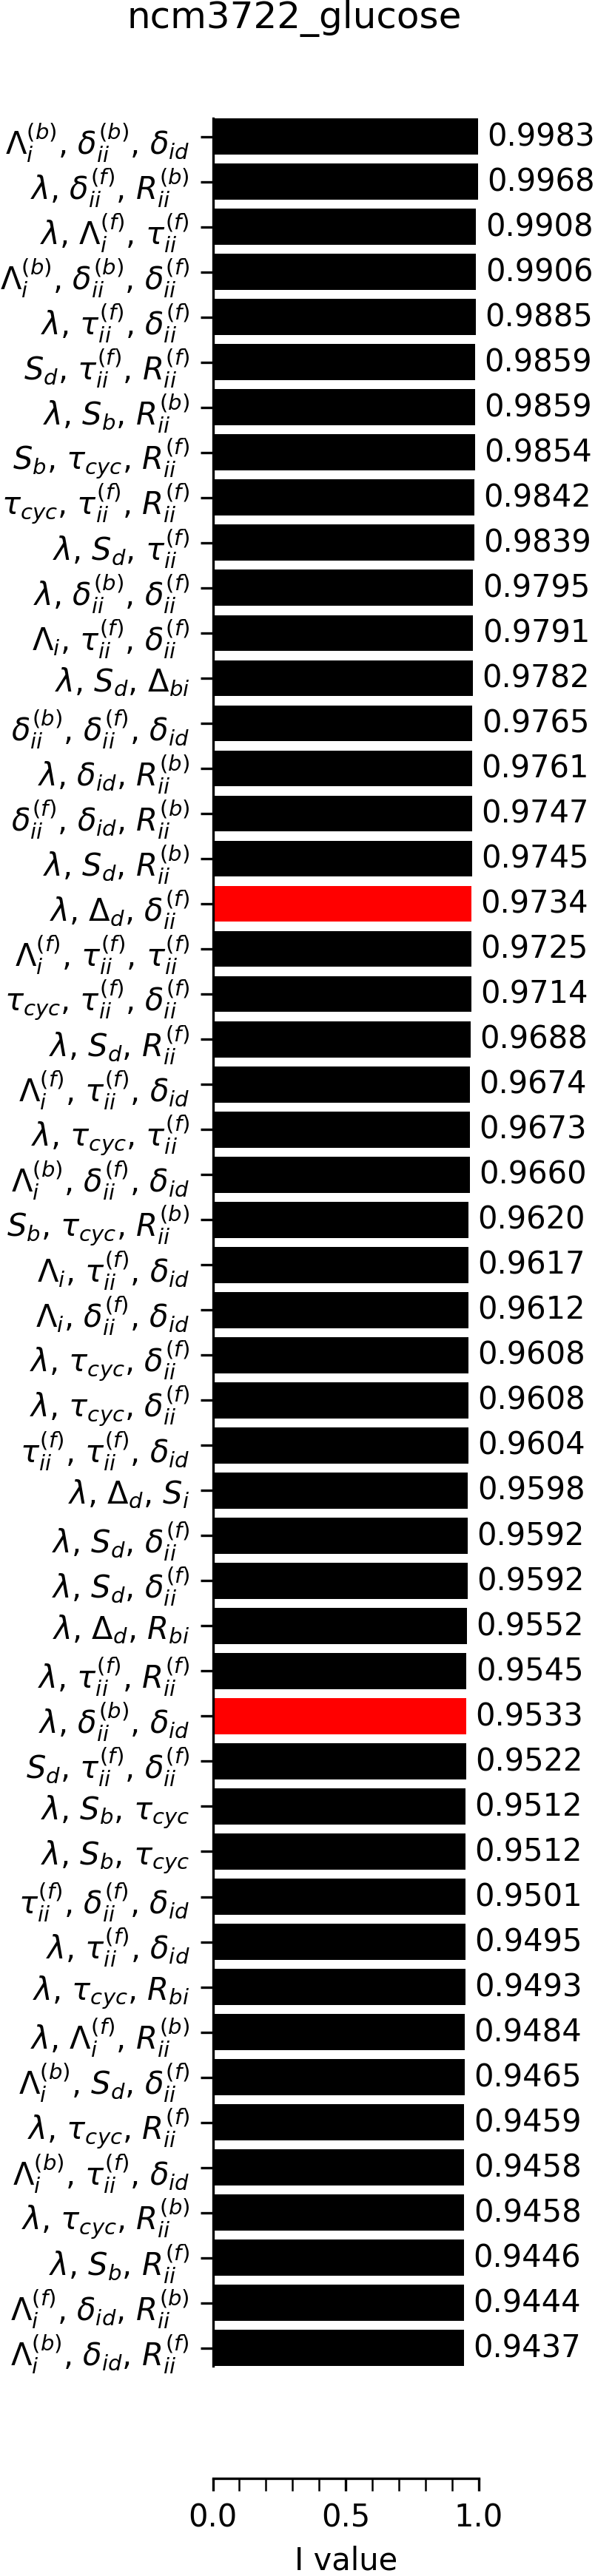

In [26]:
name = 'ncm3722_glucose'

# first figure
fname = "determinant_analysis_top{:d}".format(nval) + '.png'
fpath = os.path.join(direxp,name,fname)
# display one of the previous figures
Image(filename=fpath) 

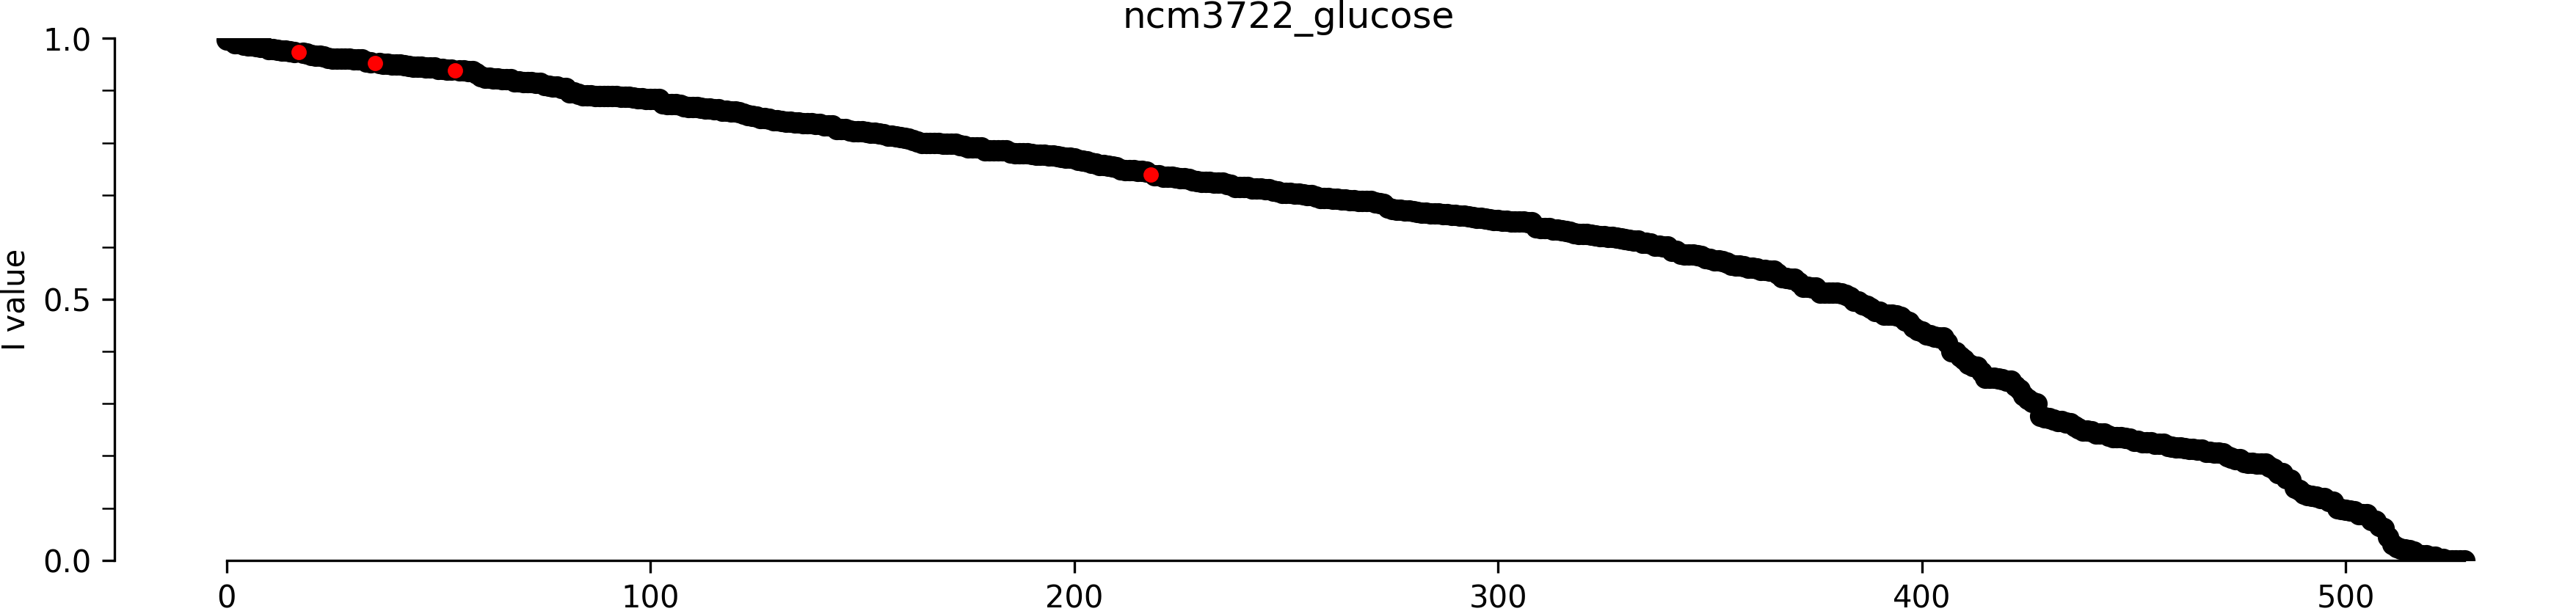

In [27]:
# second figure
fname = "determinant_analysis_all".format(nval) + '.png'
fpath = os.path.join(direxp,name,fname)
# display one of the previous figures
Image(filename=fpath) 